In this notebook we are writing an electrostatic PIC code. The standard references on PIC are Birdsall & Langdon and Hockney & Eastwood

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import os

In [2]:
#initialize nparts particles
def init_particles(nparts, L, vth_e):
    rng = np.random.default_rng(12345)
    xp = L*rng.random(nparts) #particle positions are uniformly distibuted in [0, L]
    #xp = np.random.uniform(low = L/4, high = 3*L/8, size = nparts//2)
    #xp = np.append(xp, np.random.uniform(low = L - L/4, high = L - 3*L/8, size = nparts//2) )
    #vp = np.random.normal(loc=0, scale=vth_e, size=nparts) #particle velocities have a normal distribution
    vp = rng.normal(loc=3*vth_e, scale=vth_e, size=nparts//2)
    vp = np.append(vp, rng.normal(loc=-3*vth_e, scale=vth_e, size=nparts - nparts//2))
    return xp, vp

Interpolation

NGP: $W(x) = 1$ for $|x|<dx/2$; = 0.5 for $x = dx/2$; = 0 otherwise

CIC: $W(x) = 1 - |x|/dx$ for $|x|<dx$; = 0 otherwise

In [3]:
#given particle position, return its contribution to number density
def Wt_fn(xi, rp, dx, interpolation = 'NGP'):
    if (interpolation == 'NGP'):
        return Wt_NGP(xi, rp, dx)
    elif (interpolation == 'CIC'):
        return Wt_CIC(xi, rp, dx)
    else:
        print ("Illegal option for Wt_fn")
        return
    
#NGP weight function; Following convention in Eq. (2-28) of Hockney & Eastwood
def Wt_NGP(xi, rp, dx): #xi: grid location; rp: particle location; dx: grid spacing
    if (abs(xi-rp) < 0.5*dx):
        return 1
    elif (abs(xi-rp) == 0.5*dx):
        return 0.5
    else:
        return 0

#CIC weight function
def Wt_CIC(xi, rp, dx): #xj: grid location; ri: particle location; dx: grid spacing
    if (abs(xi-rp) < dx):
        return (dx - abs(xi-rp))/dx
    else:
        return 0

In [4]:
#find the cell coordinates between which the particle lies; uses bisection
def left_right(xpp, x): #given particle coordinate and grid, find the left & right grids
    dx = x[1] - x[0]
    imin = int(xpp//dx)
    imax = imin + 1
    '''
    #no need for bisection for uniform grid!
    imax = np.size(x)-1
    imin = 0
    while (imax > imin+1):
        imid = (imin+imax)//2
        if (xpp < x[imid]):
            imax = imid
        if (xpp > x[imid]):
            imin = imid
    '''
    return imin, imax

$E = -\frac{d\phi}{dx}$ 

In [5]:
#calculate Electric field on the grid
def Efield_calc(phi, dx):
    
    nc = np.size(phi)
    E = 0.0*phi
    E[0] = -0.5*(phi[1]-phi[nc-2])/dx
    for i in range(1,nc-1):
        E[i] = -0.5*(phi[i+1]-phi[i-1])/dx
        
    E[nc-1] = -0.5*(phi[1]-phi[nc-2])/dx

    return E

In [6]:
#calculate electron density on grid, given the electron positions
def elec_dens(xp, x, interpolation = 'NGP'): 
    dx = x[1] - x[0]
    nc = np.size(x)
    ne_dens = np.zeros(nc)
    for xpp in xp: 
        imin, imax = left_right(xpp, x) #find the cell coordinates between which the particle lies
        ne_dens[imin] += Wt_fn(x[imin], xpp, dx, interpolation)
        ne_dens[imax] += Wt_fn(x[imax], xpp, dx, interpolation)
        
    ne_dens[0] += ne_dens[nc-1] #apply periodic BCs on electron number density
    ne_dens[nc-1] = ne_dens[0]
    
    ne_dens /= dx
        
    return ne_dens

Leap-frog time update ($x_p$ is ahead of $v_p$ by $dt/2$)

$v_p^{n+1/2} = v_p^{n-1/2} + dt a_p^n  \\
x_p^{n+1} = x_p^n + dt v_p^{n+1/2}$

In [7]:
def get_acc_p(xp, acc, dx, x, interpolation):
    nparts = np.size(xp)
    acc_loc = np.zeros(nparts)
    L = x[-1]-x[0]
    xp = xp%L #place the particles within the box
    for p in range(nparts):
        imin, imax = left_right(xp[p], x) #find the cell coordinates between which the particle lies
        if (imax >= np.size(x)):
            print(imin, imax, p, xp[p])
        acc_loc[p] = acc[imin]*Wt_fn(x[imin], xp[p], dx, interpolation) + acc[imax]*Wt_fn(x[imax], xp[p], dx, interpolation) #calculate acceleration at the location of particles
    return acc_loc

def push_LF(xp, vp, acc_loc, dt):
    nparts = np.size(xp)
    for p in range(nparts):
        vp[p] += dt*acc_loc[p] #updated velocity
        xp[p] += dt*vp[p] #updated position
        xp[p] = xp[p]%L #move particle back in the box if it moves out
    return

In [8]:
def push_particles(xp, vp, acc, dt, dx, x, L, interpolation = 'NGP'): #push particles for time dt, given acceleration on grid
    nparts = np.size(xp)
    acc_loc = get_acc_p(xp, acc, dx, x, interpolation)
    push_LF(xp, vp, acc_loc, dt)
    return

def push_only_xp(xp, vp, dt, L): #update only xp for time dt, given vp
    nparts = np.size(xp)
    for p in range(nparts): 
        xp[p] += dt*vp[p] #updated position
        xp[p] = xp[p]%L #move particle back in the box if it moves out
    return

def push_only_vp(vp, acc, dt, dx, x, interpolation = 'NGP'): #update only vp for time dt, given acceleration on grid
    acc_loc = get_acc_p(xp, acc, dx, x, interpolation)
    vp += dt*acc_loc
    return

In [9]:
def dump_fields(nfile, x, rho, phi, E, time, out_dir):
    np.savetxt(out_dir+'fields_'+str(nfile)+'.dat', np.c_[x, rho, phi, E], header = 'x, rho, phi, E at time = '+str(time))

def dump_particles(nfile, xp, vp, time, out_dir):
    np.savetxt(out_dir+'particles_'+str(nfile)+'.dat', np.c_[xp, vp], header = 'xp, vp at time = '+str(time))

electrostatic Poisson equation: $\frac{d^2 \phi}{dx^2} = -4 \pi \rho$

below we are solving: $\frac{d^2 \phi}{dx^2} = RHS$

In [10]:
def potl_calc(rhs, dx, method='MAT'):
    if (method == 'MAT'):
        return potl_calc_mat(rhs, dx)
    elif (method == 'FFT'):
        return potl_calc_fft(rhs, dx)
    else:
        print("Illegal option for Poisson solver")
        return

def potl_calc_mat(rhs, dx):
#following is from Hockney & Eastwood; pg. 37 
    nc = np.size(rhs)
    phi = 0.0*rhs #phi assumed to be zero at end-points
    
    for i in range(1,nc):
        phi[1] += i*rhs[i]
        
    phi[1] /= (nc-1)
    phi[2] = rhs[1] + 2*phi[1]
    
    for i in range(3, nc):
        phi[i] = rhs[i-1] + 2*phi[i-1] - phi[i-2]
        
    phi *= dx*dx

    return phi

#solving Poisson eq in Fourier space
def potl_calc_fft(rhs, dx):
    nc = np.size(rhs)
    L = (nc-1)*dx #periodic box size
    rhs_k = np.fft.rfft(rhs[:-1])
            
    k = 2.*np.pi*np.arange((nc-1)//2+1)/L #wavenumber; using reality of rho
    phi_k = -rhs_k/(k*k + (2*np.pi/L)*(2*np.pi/L)*1e-30) #avoid 0/0 form
    phi_k[0] = 0.0 #k=0 mode has zero amplitude since mean density is zero; set to zero by hand
        
    phi = np.fft.irfft(phi_k, nc-1) #like rhs, phi in x- space should be real
        
    phi -= phi[0] #make phi at boundaries zero, this freedom is available even with periodic BCs since Poisson eq is second order
    
    phi = np.append(phi, phi[0]) #imposing periodic BCs at outer boundary
     
    return phi

In [11]:
#starting of the main program
#using CGS units; physical parameters and constants
e = 5.e-10 #charge of an electron
me = 9.1e-27 #mass of an electron
kB = 1.4e-14 #Boltzmann constant

#numerical parameters
#charge to mass ratio of superparticles = that of an electron
Ns = 1.e5 #number of electrons in a super-particle
ppc = 20 #particles per cell
nc = 1000 #number of cells 
nparts = nc*ppc #total number of particles
LbyLD = 100 #box-length in terms of Debye length

#physical parameters
Te = 1.e6 #electron temperature
vth_e = np.sqrt(kB*Te/(Ns*me)) #isothermal speed of electrons

#box-size & Debye length, number density, plasma frequency
L = vth_e*vth_e*LbyLD*LbyLD*me/(4*np.pi*Ns*e*e*nparts) #box-size
#print(L)
lam_D = L/LbyLD #Debye length 
n0 = nparts/L #number density of particles
wp = np.sqrt(4.*np.pi*n0*Ns*e*e/me) #plasma frequency

x = np.linspace(0,L,nc+1) #grid cell edges x[0] is same as x[nc] under periodic BCs; fields are located at cell edges
dx = x[1]-x[0] #uniform grid spacing

In [12]:
#time parameters
dt = 0.1/wp
tend = 15*2*np.pi/wp #run for few plasma periods
time = 0
n_dump, n_hist = 20, 100
dt_dump, dt_hist = tend/20, tend/100 #time difference between dumps of fields & particles and history files
t_dump, t_hist = 0, 0
dump, hist = True, True #want outputs at t=0
nfile_dump = 0

In [13]:
interpolation = 'CIC' #interpolation method for charge & acceleration
method = 'FFT' #method to solve Poisson equation

#initialization
xp, vp = init_particles(nparts, L, vth_e) #initialize particles at same time
ne_dens = elec_dens(xp, x, interpolation) #calculate electron density over the grid from electron locations
#edge electron densities are same and should not be counted twice in averaging
ni_dens = np.mean(ne_dens[:-1]) #ion density = average electron density (constant in time)

rho = Ns*e*(ni_dens - ne_dens) #charge density on the grid, with neutralizing ion background
phi = potl_calc(-4*np.pi*rho, dx, method) #calculate potential, given the charge density
E = Efield_calc(phi, dx) #calculate E, given the potential
acc = -e*E/me #acceleration over the grid

push_only_vp(vp, acc, -0.5*dt, dx, x, interpolation) #update vp by -dt/2 to use leapfrog scheme

In [14]:
#create directory to dump data
out_dir = os.getcwd()+'/LF/'
if (os.path.exists(out_dir) == False):
    os.mkdir(out_dir)
    
#now evolve equations in time
time_hist, KE_hist, PE_hist, totE_hist = [], [], [], [] #initialize list of quantities to be dumped in history dump
while (time < tend):
    dt = min(dt*(1+1e-11), tend-time)
    time += dt
    if (t_dump > dt_dump or time == tend):
        t_dump = 0 #reset dump time
        dump = True
    if (t_hist > dt_hist or time == tend):
        t_hist = 0 #reset hist time
        hist = True
        
    if (dump): 
        push_only_vp(vp, acc, 0.5*dt, dx, x, interpolation) #increment velocity by dt/2 to bring (xp, vp) at same time
        #dump data
        dump_fields(nfile_dump, x, rho, phi, E, time, out_dir)
        dump_particles(nfile_dump, xp, vp, time, out_dir)
        push_only_vp(vp, acc, -0.5*dt, dx, x, interpolation) #increment velocity by -dt/2 to make (xp, vp) offset again by dt/2
        nfile_dump += 1
        dump = False

    if (hist):
        push_only_vp(vp, acc, 0.5*dt, dx, x, interpolation) #increment velocity by dt/2 to bring (xp, vp) at same time
        kin_energy = 0.5*Ns*me*np.sum(vp**2)
        pot_energy = 0.5*dx*np.sum(rho*phi) #0.5 in PE necessary since this is self-consistent field
        energy = kin_energy + pot_energy
        time_hist.append(time)
        KE_hist.append(kin_energy)
        PE_hist.append(pot_energy)
        totE_hist.append(kin_energy+pot_energy)
        push_only_vp(vp, acc, -0.5*dt, dx, x, interpolation) #increment velocity by -dt/2 to make (xp, vp) offset again by dt/2
        hist = False
        
    t_dump += dt
    t_hist += dt
    
    push_particles(xp, vp, acc, dt, dx, x, L, interpolation) #push particles; main place where particles are pushed 
        
    ne_dens = elec_dens(xp, x) #calculate electron density over the grid
    rho = Ns*e*(ni_dens - ne_dens) #charge density on the grid, with neutralizing ion background
    phi = potl_calc(-4*np.pi*rho, dx, method) #calculate potential, given the charge density
    E = Efield_calc(phi, dx) #calculate E, given the potential
    acc = -e*E/me #acceleration over the grid
    
np.savetxt(out_dir+'hist.dat', np.c_[time_hist, KE_hist, PE_hist, totE_hist], header = 'time, KE, PE, total energy')

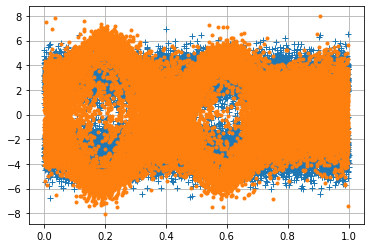

In [15]:
#plot phase-space plots
D = np.loadtxt(out_dir+'particles_0.dat')
plt.plot(D[:,0]/L,D[:,1]/vth_e,'+')

'''
D = np.loadtxt(out_dir+'particles_1.dat')
plt.plot(D[:,0]/L,D[:,1]/vth_e,'^')

D = np.loadtxt(out_dir+'particles_2.dat')
plt.plot(D[:,0]/L,D[:,1]/vth_e,'^')
'''

D = np.loadtxt(out_dir+'particles_20.dat')
plt.plot(D[:,0]/L,D[:,1]/vth_e,'.')

plt.grid()

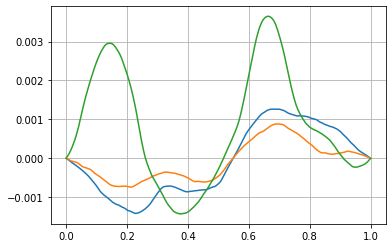

In [16]:
#field profiles
D = np.loadtxt(out_dir+'fields_0.dat')
plt.plot(D[:,0]/L,D[:,2],'-')

D = np.loadtxt(out_dir+'fields_1.dat')
plt.plot(D[:,0]/L,D[:,2],'-')

D = np.loadtxt(out_dir+'fields_10.dat')
plt.plot(D[:,0]/L,D[:,2],'-')
plt.grid()

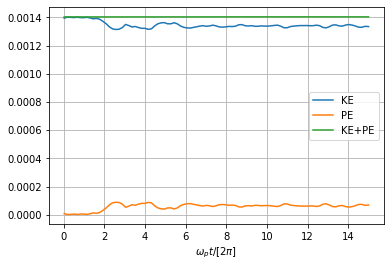

In [17]:
#energy diagnostics
D = np.loadtxt(out_dir+'hist.dat')
tplot = D[:,0]*wp/(2*np.pi)
plt.plot(tplot, D[:,1], label = 'KE')
plt.plot(tplot, D[:,2], label = 'PE')
plt.plot(tplot, D[:,3], label = 'KE+PE')
plt.xlabel(r'$\omega_p t/[2\pi]$')
plt.legend()
plt.grid()
#plt.xlim([0.5,10])

In [18]:
#basic checks, periodicity, etc.
print(nc)
print(phi[0], phi[nc])
print(rho[0], rho[nc])
print(E[0], E[nc])

1000
0.0 0.0
-0.673198425769242 -0.673198425769242
-0.02486349563836574 -0.02486349563836574


In [19]:
print(np.mean(rho[:-1]))
print(np.mean(E[:-1]))

-3.481659405224491e-16
1.7763568394002505e-18
